In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.spatial import distance
import time
import os
import sys

In [ ]:
UNDEFINED = 0
NOISE = 1
EPS =  0
RADIUS = 2
TRESHOLD = 5*RADIUS       # (8*EPS)/2   (0, 5)
ORIGINAL_STDOUT = sys.stdout

In [ ]:
class DBScan():
    def __init__(self, mat):
        self.mat = mat
        self.r = RADIUS
        self.e = EPS
        self.t = TRESHOLD
        self.distance = distance.minkowski

        self.dim = mat.shape    # x, y, z
        self.label = np.array([[UNDEFINED for _ in range(self.dim[1])] for _ in range(self.dim[0])])
        # print(self.label.shape, self.dim)

    def query_radius(self, pos):
        i, j = pos
        result = []
        coords = list(range(-self.r, self.r + 1))
        cont = 0
        for x in coords:
            for y in coords:
                curr_i, curr_j = (i + x, j + y)
                if curr_i == i and curr_j == j:
                    continue
                if 0 <= curr_i < self.dim[0] and 0 <= curr_j < self.dim[1]:
                    result.append((curr_i, curr_j))
                else: 
                    continue
                cont += 1
        return result

    def run(self):
        c = 1
        # print(f'self.dim {self.dim}')    

        for curr_pos in [(f, s) for f in range(self.dim[0]) for s in range(self.dim[1])]:
            label_p = self.label[curr_pos]
            
            if label_p != UNDEFINED:
                continue

            NN = [coord for coord in self.query_radius(curr_pos) if self.distance(self.mat[curr_pos], self.mat[coord]) <= EPS]

            if len(NN) < self.t:
                self.label[curr_pos] = NOISE
                continue

            c += 1
            self.label[curr_pos] = c
            
            S = NN
            ls = len(S)
            idx = 0

            while idx < ls:
                q = S[idx]
                idx += 1
                label_curr = self.label[q]
                if label_curr == NOISE:
                    self.label[q] = c
                if label_curr != UNDEFINED:
                    continue
                NE = [coord for coord in self.query_radius(q) if self.distance(self.mat[q], self.mat[coord]) <= EPS]
                self.label[q] = c
                if len(NE) < self.t:
                    continue
                not_S = [_ for _ in NE if _ not in S and _ != curr_pos]
                S += not_S
                ls = len(S)
    
        pixels = pd.DataFrame()
        pixels['x'] = np.array([[_]*self.dim[1] for _ in range(self.dim[0])]).flatten()
        pixels['y'] = list(range(self.dim[1])) * self.dim[0]
        pixels['label'] = self.label.flatten()

        return self.label, pixels

In [ ]:
IMG_PATH = './mini_data/'

# **SIMULACIÓN**

In [ ]:
def preprocesamiento(path):
    img = Image.open(path)

    # resizing
    H, W = img.size
    h, w = img.size
    k = 1

    while h >= 100 or w >= 100:
        k += 1
        h = H/k
        w = W/k

    img = img.resize((int(h), int(w))).convert('1')
    mat = np.asarray(img).astype(int)
    return mat

Cluster labels: [2 1 3 4 5 6]
Cluster labels: [2 1 3 4 5 6 7 8]
Cluster labels: [2 1]
Cluster labels: [2 1 3 4 5 6]
Cluster labels: [2 1 3]


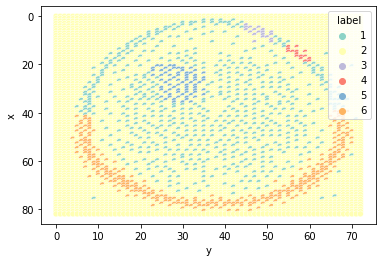

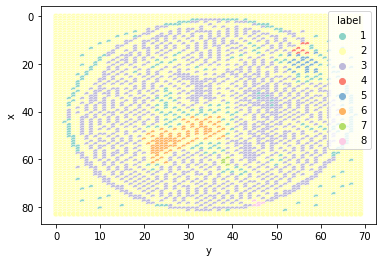

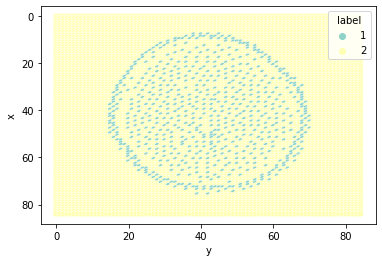

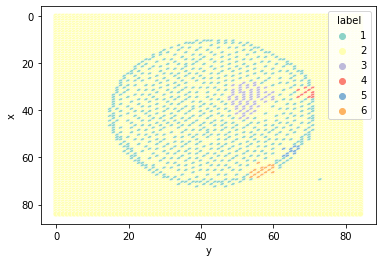

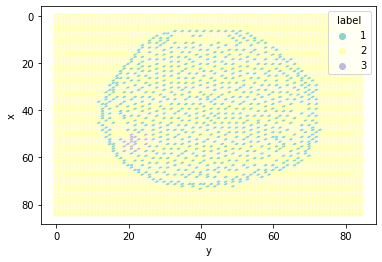

In [450]:
for f in os.listdir(IMG_PATH):
    dbs = DBScan(preprocesamiento(IMG_PATH+f))
    result, pixels = dbs.run()

    fig = plt.figure()
    sns.scatterplot(data=pixels, x='y', y='x', hue='label', palette='Set3' )
    plt.gca().invert_yaxis()
    pixels.to_csv( './Resultados/DBScan/' + f.replace('.jpg', '.csv'), index=False)
    plt.savefig('./Resultados/DBScan/' + f.replace('.jpg', '.png'), dpi=1500)
    print(f'Cluster labels: { pixels["label"].unique() }')
    

## **Layer analysis**

In [ ]:
"""
* Plotea cada uno de los clusters resultantes
"""

# plt.clf()
# for _ in list(pixels['label'].unique()):
#     current = pixels[pixels['label'] == _]
    
#     X = current['y'].tolist()
#     Y = current['x'].tolist()

#     fig = plt.figure()
#     plt.title(f'Cluster {_}')
#     plt.scatter(X, Y, c=current['label'].tolist(), s=8, cmap='Dark2')
#     plt.xlim(0, mat.shape[1])
#     plt.ylim(0, mat.shape[0])
#     plt.gca().invert_yaxis()

## **Tumor removal**

In [ ]:
"""
* Plotea las capas que se elijan como el tumor
"""
# fig = plt.figure()
# sns.scatterplot(data=pixels[pixels['label'].isin(["Poner aca las etiquetas correspondientes al tumor"])], x='y', y='x', hue='label', palette='viridis' )
# plt.xlim(0, mat.shape[1])
# plt.ylim(0, mat.shape[0])
# plt.gca().invert_yaxis()